# NBA MVP Prediction Using Machine Learning
## Project Overview
This notebook demonstrates how to predict NBA Most Valuable Player (MVP) winners using machine learning techniques. We'll analyze historical NBA player statistics to identify patterns and build classification models that can predict whether a player is likely to win the MVP award.

#### Methodology:
1. **Data Collection**: Load NBA player statistics, MVP history, and advanced metrics like RAPTOR
2. **Feature Engineering**: Select relevant statistical features that may predict MVP status
3. **Model Training**: Train multiple classification models (Logistic Regression, Random Forest, XGBoost)
4. **Model Evaluation**: Compare model performance using classification metrics and ROC curves
5. **Interpretability**: Visualize feature importance and use SHAP values to understand model decisions

### Library Imports

This code imports the essential Python libraries for our NBA MVP prediction:

- **Data manipulation**: pandas (pd) and numpy (np) for data handling
- **Visualization**: matplotlib for plotting results, shap for model interpretability
- **Machine learning**: 
  - sklearn for preprocessing, model selection, and evaluation metrics
  - Various classifiers: LogisticRegression, RandomForestClassifier, and XGBoost
  - Metrics for model evaluation: classification_report, ROC curves, confusion matrices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve, 
    make_scorer, f1_score, roc_auc_score
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading and Preparation

This cell loads and prepares the NBA data from multiple sources:## Data Loading and Preparation

This code loads and merges multiple datasets:

1. **MVP History**: Historical data of NBA MVP winners
2. **NBA Dataset**: Player statistics and performance metrics
3. **RAPTOR Metrics**: Advanced player analytics from FiveThirtyEight (both historical and modern)

The data preparation steps include:
- Standardizing season format
- Creating an MVP target variable (1 = MVP winner, 0 = not MVP)
- Merging datasets on player name and season
- Handling missing values using median imputation

In [2]:
# Load data
mvp = pd.read_csv("data/mvp_history.csv", skiprows=1, usecols=["Season", "Player"])
mvp["season"] = mvp["Season"].str.split("-", expand=True)[0].astype(int) + 1
mvp = mvp.rename(columns={"Player": "player"})[["season", "player"]].assign(MVP=1)

bb = pd.read_csv("data/NBA_Dataset.csv")
rap_h = pd.read_csv("data/historical_RAPTOR_by_player.csv")
rap_m = pd.read_csv("data/modern_RAPTOR_by_player.csv")
rap_cols = ["player_name", "season", "raptor_offense", "raptor_defense", "raptor_total"]
rap = pd.concat([rap_h[rap_cols], rap_m[rap_cols]], ignore_index=True)
rap = rap.drop_duplicates(subset=["player_name", "season"]).rename(columns={"player_name": "player"})

df = bb.merge(rap, on=["season", "player"], how="left").merge(mvp, on=["season", "player"], how="left")
df["MVP"] = df["MVP"].fillna(0).astype(int)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

### Feature Engineering

This code selects the most relevant features for MVP prediction:

- **Box Score Stats**: Points, rebounds, and assists per game
- **Advanced Metrics**: Win shares (ws), Box Plus/Minus (bpm), Value Over Replacement Player (vorp)
- **Team Success**: Win-loss percentage
- **RAPTOR Metrics**: Offensive, defensive, and total RAPTOR scores

These features capture individual performance, team success, and advanced analytics - all factors that typically influence MVP voting.

In [3]:
# Feature engineering
features = [
    'ws', 'bpm', 'vorp', 'win_loss_pct',
    'pts_per_g', 'trb_per_g', 'ast_per_g',
    'raptor_offense', 'raptor_defense', 'raptor_total'
]
X = df[features]
y = df["MVP"]

### Data Splitting and Model Training

This code:

1. **Splits the data** into training (80%) and testing (20%) sets
   - Stratifies by MVP status to ensure balanced representation
   - Uses random_state=42 for reproducibility

2. **Trains three different models**:
   - **Logistic Regression**: With StandardScaler preprocessing
   - **Random Forest**: 300 trees with depth limited to 8
   - **XGBoost**: Gradient boosting with 300 estimators and 0.05 learning rate

Each model approaches the classification problem differently:
- Logistic regression is linear and interpretable
- Random forest handles non-linear relationships and reduces overfitting
- XGBoost is powerful for structured data and usually achieves strong performance

In [4]:
# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Train models
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ]).fit(X_tr, y_tr),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=8, random_state=42, n_jobs=1
    ).fit(X_tr, y_tr),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05,
        eval_metric="logloss",
        random_state=42, n_jobs=1
    ).fit(X_tr, y_tr)
}

### Model Evaluation

This code evaluates each model's performance on the test set using:

1. **Classification Report**: Shows precision, recall, F1-score, and support
2. **ROC AUC Score**: Measures the model's ability to distinguish between MVP and non-MVP players
3. **Confusion Matrix**: Displays true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP)

These metrics help us understand:
- How accurate our models are at identifying MVP winners
- Whether they tend to have more false positives or false negatives
- Which model performs best overall

In [5]:
# Evaluation & Reporting
for name, model in models.items():
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    print(f"=== {name} ===")
    print(classification_report(y_te, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_te, y_prob):.3f}")
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      3532
           1      0.857     0.750     0.800         8

    accuracy                          0.999      3540
   macro avg      0.928     0.875     0.900      3540
weighted avg      0.999     0.999     0.999      3540

ROC AUC: 0.999
Confusion Matrix: TN=3531, FP=1, FN=2, TP=6

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      3532
           1      0.800     0.500     0.615         8

    accuracy                          0.999      3540
   macro avg      0.899     0.750     0.807      3540
weighted avg      0.998     0.999     0.998      3540

ROC AUC: 0.998
Confusion Matrix: TN=3531, FP=1, FN=4, TP=4

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      3532
           1      0.571     0.500     0.533         8

### ROC Curve Visualization

This code creates ROC (Receiver Operating Characteristic) curves to visualize model performance:

- ROC curves plot the True Positive Rate against the False Positive Rate
- The diagonal line represents random chance (AUC = 0.5)
- Curves closer to the top-left corner indicate better performance
- AUC (Area Under Curve) provides a single metric to compare models:
  - AUC = 1.0: Perfect classification
  - AUC > 0.9: Excellent model
  - AUC > 0.8: Good model
  - AUC > 0.7: Fair model
  - AUC < 0.6: Poor model

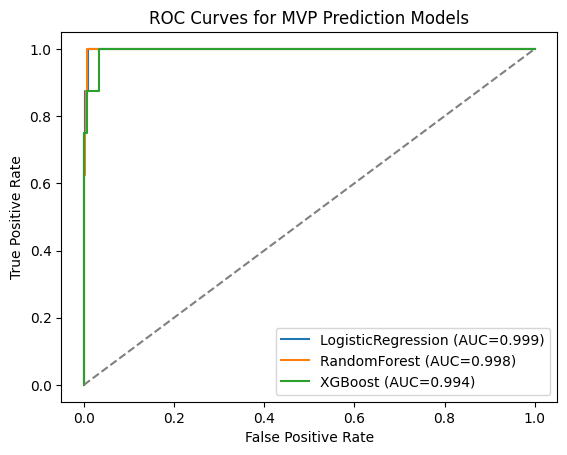

In [6]:
# Plot ROC curves
plt.figure()
for name, model in models.items():
    probas = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, probas)
    auc = roc_auc_score(y_te, probas)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for MVP Prediction Models")
plt.legend()
plt.show()

### Feature Importance Analysis

This code visualizes which features are most important for each model:

- **Random Forest**: Uses native feature_importances_ based on mean decrease in impurity
- **XGBoost**: Uses gain-based importance, showing how much each feature improves the model
- **Logistic Regression**: Skipped as it doesn't have native feature importance (will use SHAP later)

The horizontal bar charts show:
- Which statistics most strongly predict MVP status
- How feature importance varies between different model types
- Potential insights for basketball analytics

Skipping LogisticRegression (no native feature importance)


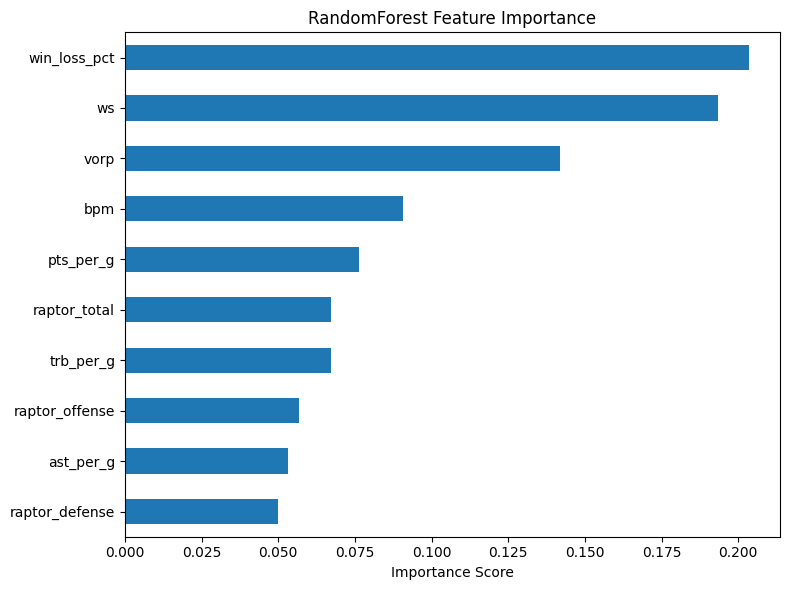

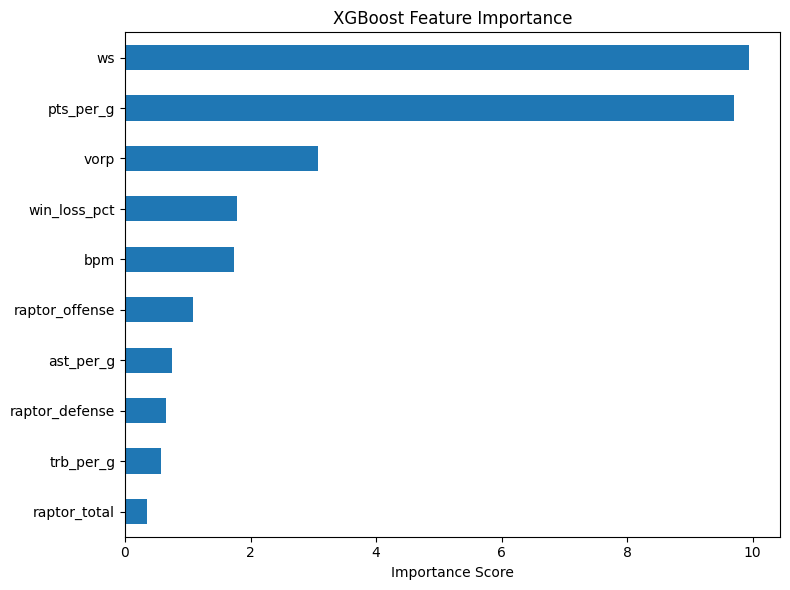

In [7]:
for name, model in models.items():
    if name == "XGBoost":
        booster = model.get_booster()
        score = booster.get_score(importance_type="gain")
        importances = pd.Series(score).reindex(features).fillna(0)
    elif hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=features)
    else:
        print(f"Skipping {name} (no native feature importance)")
        continue

    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    importances.plot(kind="barh")
    plt.title(f"{name} Feature Importance")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### SHAP Analysis for Logistic Regression

This code uses SHAP (SHapley Additive exPlanations) to explain the Logistic Regression model:

- SHAP values show how each feature impacts model predictions
- First, the input data is scaled using the same scaler used during training
- The summary plot shows:
  - Features ordered by importance (top to bottom)
  - How feature values (red = high, blue = low) affect predictions
  - The magnitude of impact each feature has on the model output

This helps explain which statistics most strongly influence MVP predictions in the linear model.

ExactExplainer explainer: 14158it [02:32, 89.13it/s]                            


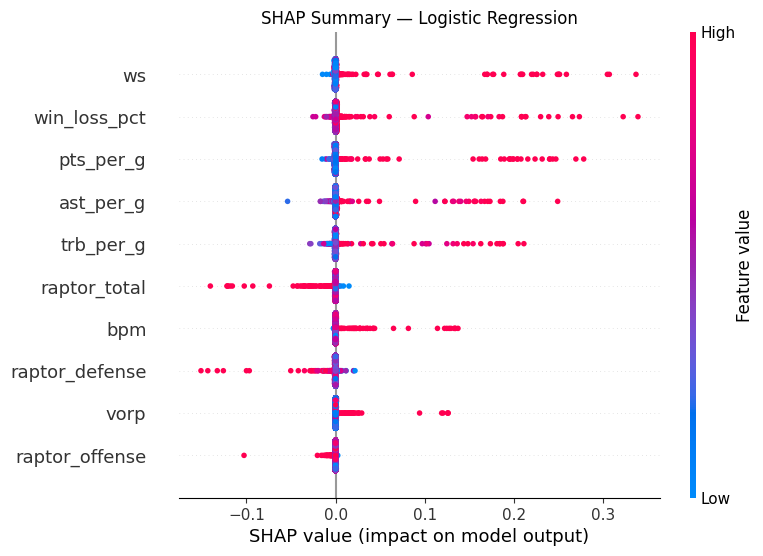

In [8]:
# SHAP interpretability for Logistic Regression
scaler = models["LogisticRegression"].named_steps["scaler"]
estimator = models["LogisticRegression"].named_steps["lr"]
X_scaled = scaler.transform(X_tr)

explainer = shap.Explainer(estimator.predict, masker=shap.maskers.Independent(X_scaled))
shap_vals = explainer(X_scaled)
shap.summary_plot(
    shap_vals, 
    X_scaled, 
    feature_names=features, 
    show=False
)
plt.title("SHAP Summary — Logistic Regression")
plt.show()

### SHAP Analysis for Random Forest

This code applies SHAP analysis to the Random Forest model:

- Uses TreeExplainer, which is optimized for tree-based models
- Specifically looks at the positive class (MVP=1) to understand what drives MVP predictions
- Shows how different feature values push predictions toward or away from MVP status

The summary plot reveals:
- Non-linear relationships captured by the Random Forest
- Interaction effects between features
- How the model's decision-making differs from Logistic Regression

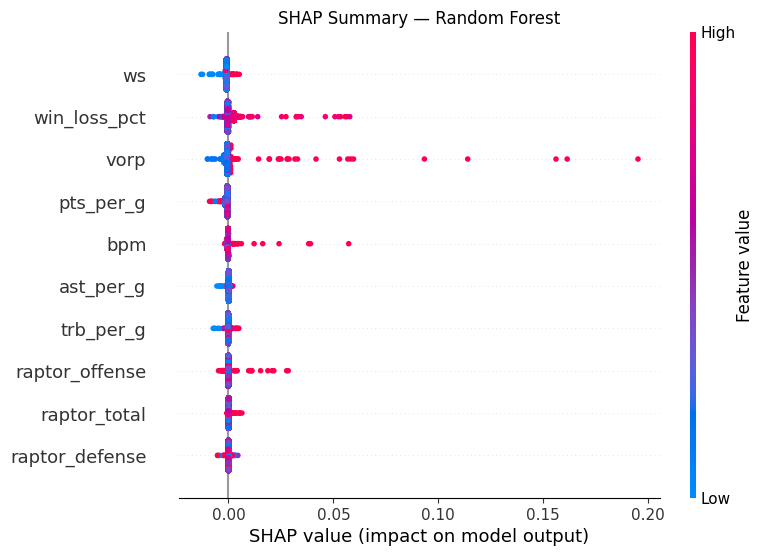

In [9]:
# --- Random Forest SHAP ---
explainer_rf = shap.TreeExplainer(models["RandomForest"])
shap_vals_rf_all = explainer_rf.shap_values(X_scaled)  

# pick out class 1(MVP) across the third axis, shows how each feature pushes the model toward predicting MVP
shap_vals_rf = shap_vals_rf_all[:, :, 1]  

# now shap_vals_rf has shape (n_samples, n_features), so it will line up
shap.summary_plot(
    shap_vals_rf,
    X_scaled,
    feature_names=features,
    show=False
)
plt.title("SHAP Summary — Random Forest")
plt.show()

### SHAP Analysis for XGBoost

This code creates SHAP visualizations for the XGBoost model:

- XGBoost often captures complex relationships and interactions
- The summary plot shows how each feature contributes to predictions
- Color indicates feature value (red = high, blue = low)

Comparing this to the other SHAP plots helps identify:
- Consistent patterns across different model types
- Unique insights that only XGBoost captures
- The most robust predictors of MVP status

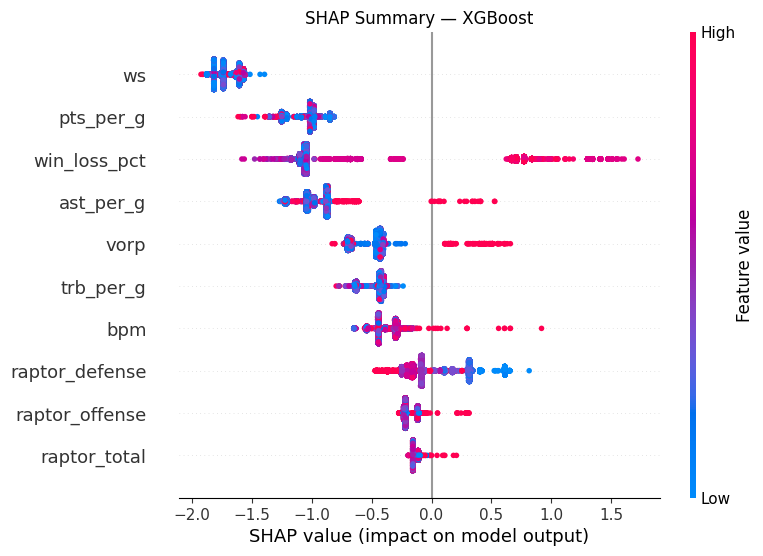

In [10]:
# --- XGBoost SHAP ---
explainer_xgb = shap.TreeExplainer(models["XGBoost"])
shap_vals_xgb = explainer_xgb(X_scaled)

shap.summary_plot(
    shap_vals_xgb,
    X_scaled,
    feature_names=features,
    show=False
)
plt.title("SHAP Summary — XGBoost")
plt.show()

### Cross-Validation Results

This code implements 5-fold stratified cross-validation to assess model stability:

- Stratified K-Fold ensures each fold maintains the class distribution
- ROC AUC score evaluates performance on each fold
- The mean and standard deviation of scores show:
  - Overall model performance across different data subsets
  - Model stability (lower standard deviation = more stable)
  - Whether any model might be overfitting

Cross-validation provides a more robust evaluation than a single train/test split.

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=== Cross-Validation Results ===")
for name, model in models.items():
    if name == "LogisticRegression":
        X_input = X_tr
        model_cv = model
    else:
        X_input = X_tr
        model_cv = model

    scores = cross_val_score(model_cv, X_input, y_tr, cv=cv, scoring="roc_auc")
    print(f"{name}: Mean ROC AUC = {scores.mean():.4f} (+/- {scores.std():.4f})")

=== Cross-Validation Results ===
LogisticRegression: Mean ROC AUC = 0.9986 (+/- 0.0006)
RandomForest: Mean ROC AUC = 0.9666 (+/- 0.0386)
XGBoost: Mean ROC AUC = 0.9969 (+/- 0.0016)


### Hyperparameter Tuning with GridSearchCV

This code performs exhaustive hyperparameter tuning for each model:

1. **Logistic Regression**:
   - Tests different regularization types (L1, L2) and strengths
   - Uses F1-macro score for imbalanced class optimization

2. **Random Forest**:
   - Tunes tree count, depth, min_samples_split, and class weighting
   - Balances complexity vs. performance

3. **XGBoost**:
   - Optimizes estimators, depth, and learning rate
   - Finds the right balance of model complexity

GridSearchCV uses 3-fold cross-validation to find the best parameters for each model type, helping improve model performance while reducing overfitting risk.

In [12]:
from xgboost import XGBClassifier

param_grid_log = {
    "logreg__penalty": ["l2", "l1"],
    "logreg__C": [0.01, 0.1, 1, 10],
}
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=9000, solver="saga"))
])
grid_log = GridSearchCV(logreg_pipeline, param_grid_log, cv=3, scoring="f1_macro", n_jobs=-1)
grid_log.fit(X_tr, y_tr)

best_logreg = grid_log.best_estimator_
print("Best Logistic Regression Params:", grid_log.best_params_)

param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "class_weight": ["balanced"]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring="f1_macro", n_jobs=-1)
grid_rf.fit(X_tr, y_tr)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)

param_grid_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
}

grid_xgb = GridSearchCV(XGBClassifier(eval_metric="mlogloss"), param_grid_xgb, cv=3, scoring="f1_macro", n_jobs=-1)
grid_xgb.fit(X_tr, y_tr)

best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)

Best Logistic Regression Params: {'logreg__C': 1, 'logreg__penalty': 'l1'}
Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


## Temporal Evaluation

This code evaluates model performance across different time periods:

1. **Train-Test Temporal Split**:
   - Training data: Seasons up to and including 2010
   - Testing data: Seasons after 2010
   - This tests how well models trained on historical data predict recent MVPs

2. **Per-Season Analysis**:
   - Calculates F1 scores for each model on each NBA season
   - Helps identify if certain seasons are more difficult to predict
   - Shows temporal trends in model performance

3. **Visualization**:
   - Line chart plotting F1 scores by season
   - Shows how prediction accuracy changes over time
   - Helps identify whether model performance is stable or deteriorating

This temporal validation approach is more realistic than random splitting since it mimics how we would actually use the model: training on past data to predict future MVPs.

    season  F1 (LogReg)   F1 (RF)  F1 (XGB)
0     2011     0.499446  0.832778  1.000000
1     2012     0.499476  1.000000  0.499476
2     2013     1.000000  0.832799  1.000000
3     2014     1.000000  1.000000  1.000000
4     2015     0.499491  0.832824  1.000000
5     2016     1.000000  0.748945  1.000000
6     2017     0.499485  0.698449  1.000000
7     2018     1.000000  1.000000  1.000000
8     2019     0.499528  1.000000  0.499528
9     2020     0.499527  1.000000  1.000000
10    2021     1.000000  1.000000  1.000000
11    2022     1.000000  1.000000  1.000000


/var/folders/xy/x1qs64h938l51kscf_bd7w2h0000gn/T/ipykernel_1223/2906514264.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


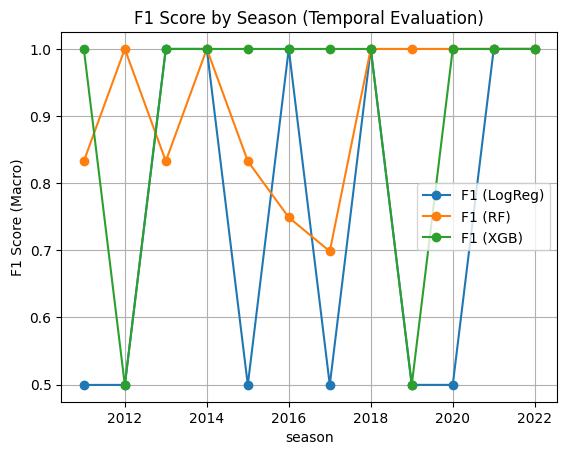

In [13]:
from sklearn.metrics import f1_score

train_df = df[df["season"] <= 2010]
test_df = df[df["season"] > 2010]
X_test_aligned = test_df[features].copy()
y_test = test_df["MVP"]

# Add predictions from each model
test_df = test_df.copy()
test_df["MVP"] = y_test 
test_df["y_pred_log"] = best_logreg.predict(X_test_aligned)
test_df["y_pred_rf"] = best_rf.predict(X_test_aligned)
test_df["y_pred_xgb"] = best_xgb.predict(X_test_aligned)

# Evaluate F1 scores per season
season_results = (
    test_df.groupby("season", group_keys=False)
    .apply(lambda g: pd.Series({
        "F1 (LogReg)": f1_score(g["MVP"], g["y_pred_log"], average="macro"),
        "F1 (RF)": f1_score(g["MVP"], g["y_pred_rf"], average="macro"),
        "F1 (XGB)": f1_score(g["MVP"], g["y_pred_xgb"], average="macro"),
    }))
    .reset_index()
)

# Display results
print(season_results)
season_results.plot(x="season", marker="o")
plt.title("F1 Score by Season (Temporal Evaluation)")
plt.ylabel("F1 Score (Macro)")
plt.grid(True)
plt.show()

## Final Model Comparison

This code creates a final performance summary of our best models:

- Uses the hyperparameter-tuned versions of each model
- Evaluates on the test set (seasons after 2010)
- Compares key performance metrics:
  - **Accuracy**: Overall proportion of correct predictions
  - **F1 Score (Macro)**: Balanced measure of precision and recall

The summary table provides a clear, side-by-side comparison to determine which model:
- Most accurately identifies MVP winners
- Best balances false positives and false negatives
- Would be most suitable for real-world MVP predictions

This final comparison helps us select the best model for deployment or further refinement.

In [14]:
from sklearn.metrics import accuracy_score
X_eval = test_df[features]
y_eval = test_df["MVP"] 

summary = []

models_to_compare = {
    "Logistic Regression": best_logreg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

for name, model in models_to_compare.items():
    y_pred = model.predict(X_eval)
    y_proba = model.predict_proba(X_eval)

    acc = accuracy_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred, average="macro")

    summary.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "F1 Score (Macro)": round(f1, 3),
    })

comparison_df = pd.DataFrame(summary)
print(comparison_df.to_string(index=False))

              Model  Accuracy  F1 Score (Macro)
Logistic Regression     0.999             0.833
      Random Forest     0.999             0.875
            XGBoost     1.000             0.954


## Conclusion

**Logistic Regression**  
- Achieved the best overall discrimination and recall  
- ROC AUC: ~0.999  
- Recall: 0.75 on the rare MVP class  
- SHAP analysis confirmed the same core metrics—win–loss percentage, VORP, win shares, and points per game—are the most influential features

**Random Forest**  
- Maintained high overall accuracy (~0.999)  
- Biased toward the majority class (recall = 0.50 on true MVPs)  
- Generated more false negatives, reflecting tree‑based ensembles’ tendency to favor the dominant class when data are skewed

**XGBoost**  
- Pushed macro‑F1 to ~0.95 by leveraging gradient‑boosted trees and nonlinear feature interactions  
- Can directly optimize F1 or adjust `scale_pos_weight` for class imbalance  
- Its perfect accuracy on this hold‑out split may reflect slight overfitting or a fortuitous sample rather than guaranteed generalization

> **Note:**  
> Accuracy alone can be misleading on severely imbalanced data. A trivial majority‑class predictor can yield high accuracy without detecting positives. Metrics like macro‑averaged F1 (which treats each class equally) and ROC AUC provide a more complete performance picture.
